# Conduction Heat Transfer: Introduction
For this set of exercises, we will be solving a **simple** conduction heat transfer problem analytically *and then numerically*. After the analytical solution is found, an input deck will be prepared that represents the geometry and material properties of the problem, so that the solution can also be found numerically, using Idaho National Lab's [MOOSE](https://mooseframework.inl.gov/index.html) (Multiphysics Object Oriented Simulation Environment) framework. All numerical solutions will be found using the [Heat Transfer Module](https://mooseframework.inl.gov/modules/heat_transfer/index.html) for this exercise. The [Tutorials](https://mooseframework.inl.gov/modules/heat_transfer/tutorials/introduction/index.html) referenced in this modules description will act as a good starting point.

# Exercise 1.A: Plane Wall (constant temperature BCs)
## Prompt / Given

For this first exercise, we will be looking at one of the simplest heat conduction problem, which consists of a wall with two different temperature boundary conditions. The relevant material properties and boundary conditions can be seen below:

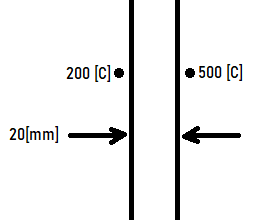

### Material & Geometry Properties:
1. Material: 316 Stainless steel
2. Thickness (T): 20 [mm] (0.02 [m])
3. Density (\$\rho\$): 8238 \$ [kg/m^3] \$
4. Specific Heat Capicity (\$C_p\$): 468 \$ [J/kg \ K] \$
5. Thermal Conductivity (\$k\$): 13.4 \$ [W/m \ K] \$

### Boundary Conditions:
1. Constant Temperature, left boundary (T): 200 \$ [C] \$ (473.15 \$ [K] \$)
2. Constant Temperature, right boundary (T): 500 \$ [C] \$ (773.15 \$ [K] \$)

### Assumptions
1. The wall has reached steady state.
2. The wall is not generating heat.
3. The wall conductivity is constant.

## Equations of state

The one dimensional heat conduction equation, according to Yunus' 5th edition *Heat and Mass Transfer* textbook, can be defined as:

$$
\frac{\partial}{\partial x} \left( k \frac{\partial T}{\partial x} \right) + 
\dot{e}_{gen} = \rho c \frac{\partial T}{\partial t}
\tag{2-13}
$$

Assuming conductivity is constant, our equation becomes: 
$$
\frac{\partial^2 \ T}{\partial \ x^2} +
\frac{\dot{e}_{gen}}{k} = 
\frac{1}{\alpha} \ 
\frac{\partial \ T}{\partial \ t}
\tag{2-14}
$$
Where \$\alpha = k / \rho c \$.
<br>
However, the wall is not generating heat and it has reached a steady state. Therefore, our equation becomes:
$$
\frac{d^2 T}{d x^2} = 0
$$

Integrading twice, we have the following general solution:

$$
T(x)=C_1 \ x + C_2
$$
And our boundary conditions are \$T(0 [m])=473 [K]\$ and \$T(0.02 [m])=773 [K]\$
Where \$C_1\$ and \$C_2\$ are constants equaling 15000 and 473.15, respectively, or:

$$
T(x)=15000(x)+473.15
$$

Let's see if we can reasonably convince our finite element analysis software to get us the same solution.

# Exercise 1.N: Plane Wall (constant temperature BCs)

## Equations of state (MOOSE)

*File name for this exercise: cht_p1n*

According to the [Heat Transfer Module](https://mooseframework.inl.gov/modules/heat_transfer/index.html) documentation page, the heat conduction equation is defined as follows:

$$
\rho(t,\vec{x}) \ c(t,\vec{x}) \frac{\partial T}{\partial t} = 
\nabla (k,\vec{x}) \nabla T + \dot{q} \ for \ \vec{x} \ \epsilon \ \Omega
$$

Where \$T\$ is temperature, \$t\$ is time \$ \vec{x} \$ is the vector spatial coordinates, \$ \rho \$ is the density, \$c\$ is the specific heat capicity, \$k\$ is the thermal conductivity and \$ \dot{q} \$ is a heat source density, and \$ \Omega \$ is the domain.

## Input File

In order to get MOOSE to solve the problem we just solved analytically, we will need to give it information about the geometry. 

## Input File: Mesh
MOOSE has many mesh generation tools build into it. For this simple geometry, all that is needed is the [GeneratedMesh](https://mooseframework.inl.gov/source/mesh/GeneratedMesh.html) object. This object can be used to create lines, squares or cubes with any dimensions and number of elements along each outer edge. In our case, the coordinate system for this mesh generating object assumes that the user is looking directly at an x and y axis on the page, while the z axis pops out of the page towards the user. Similarly, If one were to imagine a vertical mill or a CNC machine, the table would act as the x and y axis while the up and down movement of the spindle would act as the z direction, with positive being in the upwards direction. 

### Mesh Syntax
1. type = the mesh generating object to be used
2. dim = dimensions (1D, 2D, 3D)
3. nx, ny, nz = number of elements in x, y, z directions
4. xmax, ymax, zmax = upper coordinates

We don't care so much about how many elements span across the large faces of the plane wall so much as we do the elements that span from the front face to the back face... seing as to how we need to be able to resolve enough detail to get the temperature drop from one side to the other. 

For our simulation, we will arbitrarily set our xmax and ymax to 2, while our zmax will be 0.02 as mentioned in the problem statement. We will try 3 elements across the x and y directions, and then 10 across the very thin z direction. Our mesh ends up appearing as it does below:


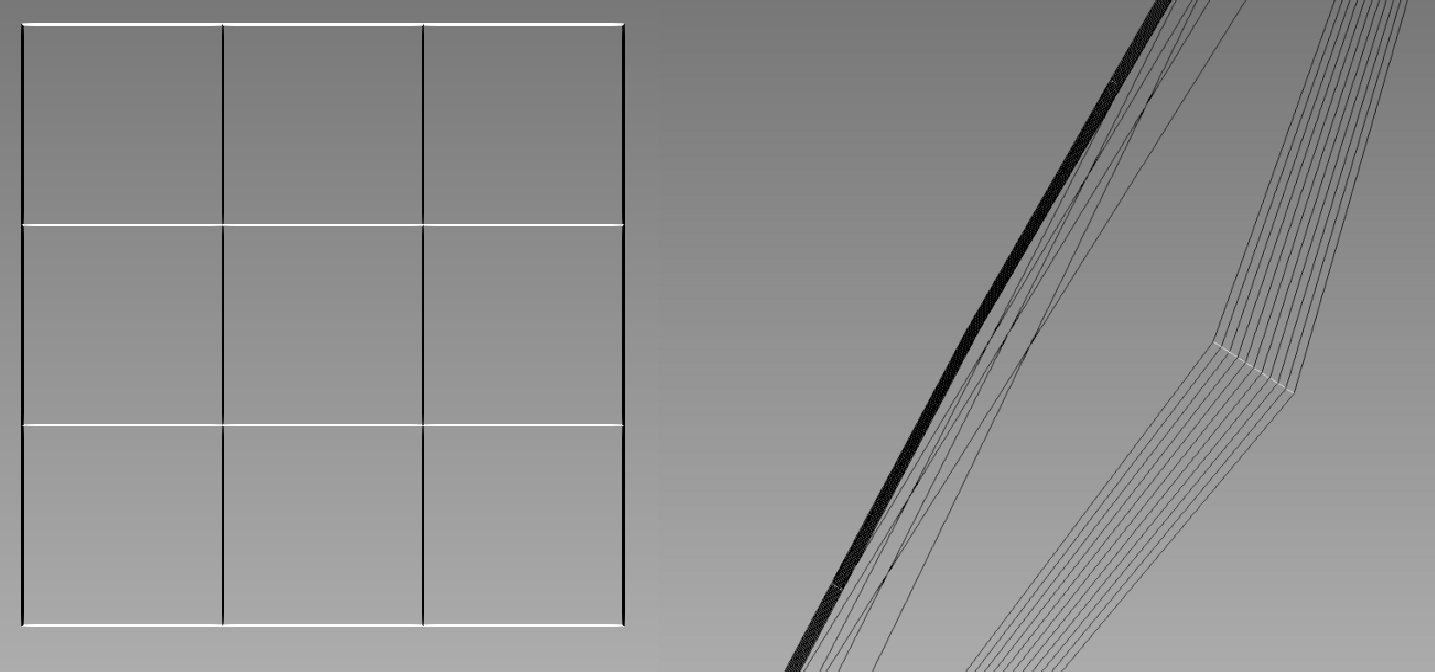


The code used for this section of the input file can be seen below:

In [ ]:
[Mesh]
  type = GeneratedMesh
  dim = 3
  nx = 3
  ny = 3
  nz = 10
  xmax = 2
  ymax = 2
  zmax = 0.02
[]

## Input File: Variables, Kernels, Materials
After defining our mesh; the variables, kernels and materials need to be defined.
### Variable Syntax
Our variable of interest is temperature so we will create a variable for it and name it "T" here. 
### Kernel Syntax
Every section of the equation of interest / equation of state needs to be represented by a section of code. In this case, a "kernel" is what we use for the conduction portion of the equation. It is defined using the type "HeatConduction" and the Variable "T" is passed into it. 
### Material Syntax
Similarily to the equation kernels, material information needs to be clarified as well. The type in this case is "HeatConductionMaterial" and the thermal_conductivity is the same value from the prompt (13.4 \$ [W/m \ K] \$)

The code used for this section of the input file can be seen below:

In [ ]:
[Variables]
  [T]
  []
[]

[Kernels]
  [heat_conduction]
    type = HeatConduction
    variable = T
  []
[]

[Materials]
  [thermal]
    type = HeatConductionMaterial
    thermal_conductivity = 13.4
  []
[]

##  Input File: BCs, VectorPostprocessors, Executioner, Outputs

### Boundary Condition Syntax
Our boundary conditions in this case are simple constant temperatures (473[K] & 773[K]) and both os these constant BCs are Dirichlet type defined on the front face and the back face of the wall plane.
### VectorPostprocessors
We will need to be able to pull data from this simulation and one method to do so involves defining the exact points that you want to check the temperature at. For this, I chose to define points at the front face, the back face and the center of the elements from front to back. An additional parameter of interest here would be the sort_by parameter. Adding this allows us to sort by id, x, y or z. 
### Executioner Syntax
The problem is steady state so the Executioner type will be steady state. 
### Output Syntax
we want to be able to plot the temperature from one side to the other, so out outputs will include a CSV file for us to place a plot on; and the exodus file so that we may visualize the temperature gradient. In addition to that, "execute_on" is used to tell the solver when to *output* the outputs. 

The code used for this section of the input file can be seen below:

In [ ]:
[BCs]
  [t_left]
    type = DirichletBC
    variable = T
    value = 473.15
    boundary = 'front'
  []
  [t_right]
    type = DirichletBC
    variable = T
    value = 773.15
    boundary = 'back'
  []
[]

[VectorPostprocessors]
  [./point_sample]
    type = PointValueSampler
    variable = 'T'
    points = '1 1 0.0  1 1 0.001  1 1 0.003  1 1 0.005  1 1 0.007  1 1 0.009  1 1 0.011  1 1 0.013  1 1 0.015  1 1 0.017  1 1 0.019  1 1 0.02'
    sort_by = id
  [../]
[]

[Executioner]
  type = Steady
[]

[Outputs]
  execute_on = TIMESTEP_END
  csv = true
  exodus = true
[]

## Results 

### Exodus file heat map
Running the script program outputs an exodus file with a temperature heat map. One view from this exodus file appears as it does below:
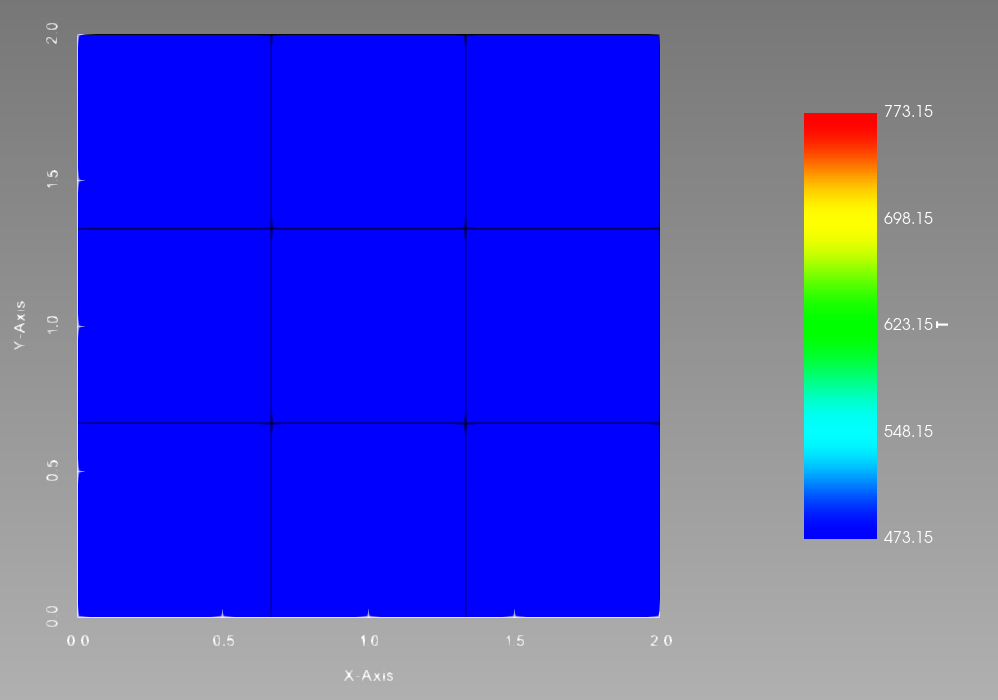

### Exodus file heat map (Edge)
Zooming in on the edge of the Exodus file shows us the temperature gradient from the front face to the back face. See below:
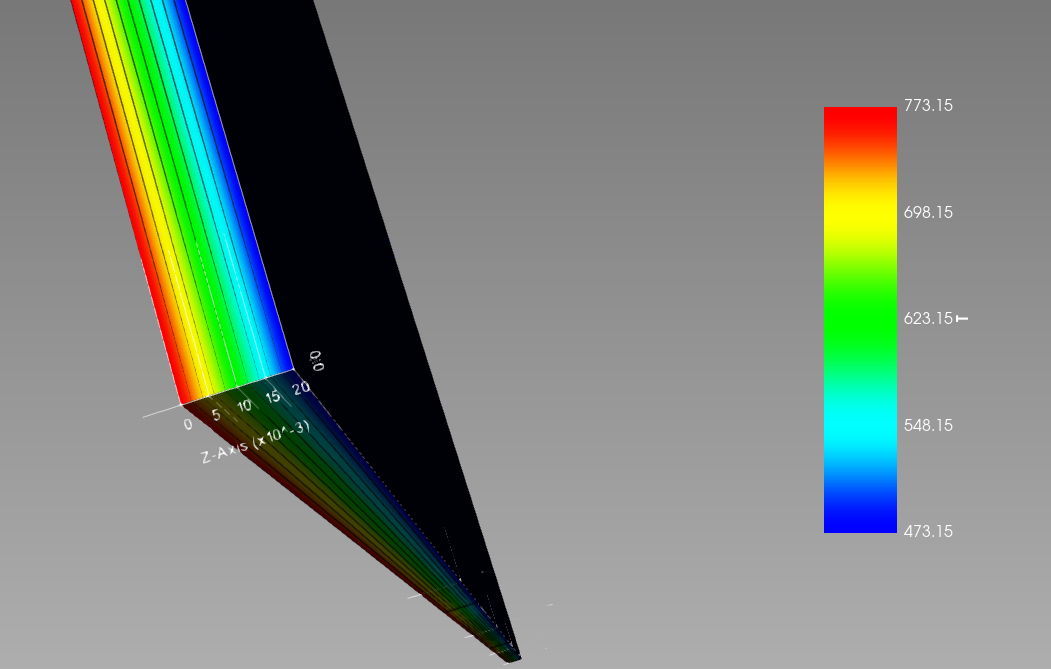

### CSV file output & plot
Pulling the data from our CSV file results in a trendline with exactly the same equation as the function uncovered in the analytical portion of the problem.

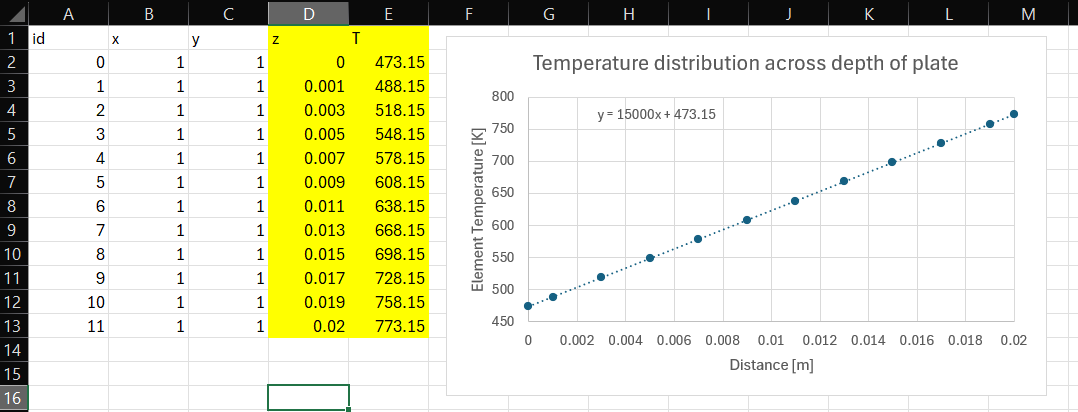

Solution function coppied below for comparison:
$$
T(x)=15000(x)+473.15
$$